In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

import tensorflow as tf
import keras
from pprint import pprint

# Load the data
movies_df = pd.read_csv('../data/movies.csv')
ratings_df = pd.read_csv('../data/ratings.csv')
tags_df = pd.read_csv('../data/tags.csv')

movie_dataset = movies_df[['movieId','title']]
movie_dataset.head()

 

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [4]:

merged_dataset = pd.merge(ratings_df, movie_dataset, how='inner', on='movieId')
merged_dataset.head()
     

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [5]:
merged_dataset[(merged_dataset['title'] == 'Toy Story (1995)') & (merged_dataset['userId'] == 94)]

,userId,movieId,rating,timestamp,title


In [6]:
refined_dataset = merged_dataset.groupby(by=['userId','title'], as_index=False).agg({"rating":"mean"})

refined_dataset.head()

,userId,title,rating
0,1,"13th Warrior, The (1999)",4.0
1,1,20 Dates (1998),4.0
2,1,"Abyss, The (1989)",4.0
3,1,"Adventures of Robin Hood, The (1938)",5.0
4,1,Alice in Wonderland (1951),5.0


In [7]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['userId'].values)
n_users = refined_dataset['user'].nunique()
     

item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['title'].values)
n_movies = refined_dataset['movie'].nunique()
     

refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(610, 9719, 0.5, 5.0)

In [8]:

refined_dataset.head()

,userId,title,rating,user,movie
0,1,"13th Warrior, The (1999)",4.0,0,48
1,1,20 Dates (1998),4.0,0,66
2,1,"Abyss, The (1989)",4.0,0,202
3,1,"Adventures of Robin Hood, The (1938)",5.0,0,245
4,1,Alice in Wonderland (1951),5.0,0,325


In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((90748, 2), (10084, 2), (90748,), (10084,))

In [10]:

n_factors = 150

In [11]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
     

X_train, X_train_array, X_train_array[0].shape


(array([[  70, 1995],
        [ 473, 2466],
        [ 565, 8982],
        ...,
        [ 479, 6713],
        [   5, 9271],
        [ 102, 5488]], dtype=int64),
 [array([ 70, 473, 565, ..., 479,   5, 102], dtype=int64),
  array([1995, 2466, 8982, ..., 6713, 9271, 5488], dtype=int64)],
 (90748,))

In [12]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)
     

In [13]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = tf.keras.layers.Embedding(n_users, n_factors, embeddings_initializer='he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(user)

u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [14]:

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 150)               91500     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 150)               1457850   ['input_2[0][0]']             
                                                                                              

In [35]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=50, epochs=100, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])


Epoch 1/100
1815/1815 [==============================] - 28s 15ms/step - loss: 0.3613 - accuracy: 0.0134 - val_loss: 0.3544 - val_accuracy: 0.0155 - lr: 0.0100
Epoch 2/100
1815/1815 [==============================] - 29s 16ms/step - loss: 0.3473 - accuracy: 0.0134 - val_loss: 0.3443 - val_accuracy: 0.0155 - lr: 0.0100
Epoch 3/100
1815/1815 [==============================] - 32s 18ms/step - loss: 0.3379 - accuracy: 0.0138 - val_loss: 0.3366 - val_accuracy: 0.0155 - lr: 0.0100
Epoch 4/100
1815/1815 [==============================] - 30s 17ms/step - loss: 0.3293 - accuracy: 0.0163 - val_loss: 0.3303 - val_accuracy: 0.0188 - lr: 0.0100
Epoch 5/100
1815/1815 [==============================] - 33s 18ms/step - loss: 0.3230 - accuracy: 0.0220 - val_loss: 0.3258 - val_accuracy: 0.0274 - lr: 0.0100
Epoch 6/100
1815/1815 [==============================] - 32s 18ms/step - loss: 0.3175 - accuracy: 0.0264 - val_loss: 0.3225 - val_accuracy: 0.0268 - lr: 0.0100
Epoch 7/100
1815/1815 [=================

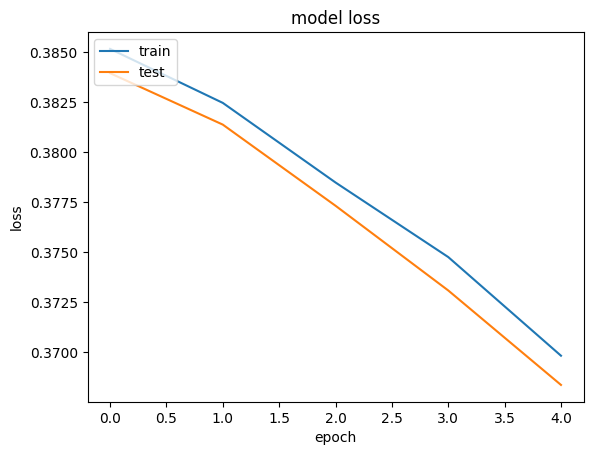

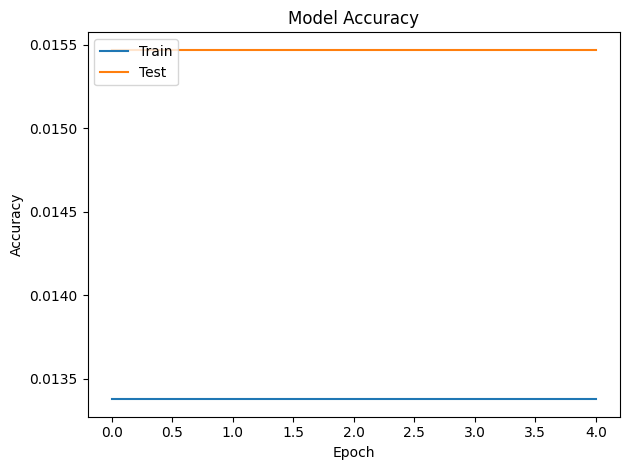

In [16]:

plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


# Plot accuracy graph

plt.plot(history.history["accuracy"][5:])
plt.plot(history.history["val_accuracy"][5:])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")

plt.tight_layout()
plt.show()

In [17]:

refined_dataset.head()

,userId,title,rating,user,movie
0,1,"13th Warrior, The (1999)",4.0,0,48
1,1,20 Dates (1998),4.0,0,66
2,1,"Abyss, The (1989)",4.0,0,202
3,1,"Adventures of Robin Hood, The (1938)",5.0,0,245
4,1,Alice in Wonderland (1951),5.0,0,325


In [18]:


X_train_array

[array([ 70, 473, 565, ..., 479,   5, 102], dtype=int64),
 array([1995, 2466, 8982, ..., 6713, 9271, 5488], dtype=int64)]

In [19]:
user_id = [47]
encoded_user_id = user_enc.transform(user_id)

seen_movies = list(refined_dataset[refined_dataset['userId'] == user_id[0]]['movie'])
print(seen_movies)

[34, 462, 501, 565, 688, 693, 830, 881, 1025, 1055, 1091, 1094, 1134, 1165, 1181, 1273, 1298, 1312, 1346, 1431, 1437, 1559, 1606, 1624, 1668, 1682, 1711, 1863, 1867, 1930, 2007, 2014, 2023, 2083, 2122, 2139, 2146, 2409, 2488, 2582, 2637, 2638, 2681, 2737, 2744, 2773, 3011, 3012, 3081, 3091, 3158, 3242, 3406, 3464, 3536, 3601, 3634, 3656, 3697, 3705, 3738, 3870, 3884, 3912, 3961, 4055, 4097, 4162, 4188, 4326, 4408, 4529, 4551, 4594, 4697, 4732, 4796, 4978, 5069, 5095, 5353, 5582, 5659, 5666, 5766, 5843, 5862, 5973, 5988, 6188, 6201, 6524, 6600, 6650, 6655, 6664, 6665, 6759, 6775, 6892, 6928, 6948, 6983, 7047, 7073, 7147, 7245, 7391, 7523, 7542, 7593, 7665, 7667, 7680, 7690, 7730, 7731, 7755, 7769, 7813, 7823, 7975, 8042, 8059, 8088, 8149, 8174, 8471, 8483, 8536, 8591, 8779, 8884, 9051, 9144, 9237, 9367, 9407, 9547, 9578]


In [20]:
len(refined_dataset['movie'].unique()), min(refined_dataset['movie']), max(refined_dataset['movie'])

(9719, 0, 9718)

In [21]:
unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
print(unseen_movies)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222

In [22]:
len(unseen_movies) + len(seen_movies)

9719

In [23]:
model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
len(model_input), len(model_input[0])

(2, 9579)

In [24]:
predicted_ratings = model.predict(model_input)
     

print(predicted_ratings.shape)

300/300 [==============================] - 1s 1ms/step
(9579, 9)


In [25]:
print(predicted_ratings)

[[8.93821895e-01 1.05797432e-01 9.21360479e-05 ... 4.88909682e-05
  3.01453911e-05 3.39387880e-05]
 [8.96079898e-01 1.03491291e-01 1.05958337e-04 ... 5.51146077e-05
  3.27934795e-05 3.87916916e-05]
 [8.95427644e-01 1.04145385e-01 1.06961983e-04 ... 5.37185551e-05
  3.26718764e-05 3.88291664e-05]
 ...
 [8.91677320e-01 1.07919000e-01 9.92832865e-05 ... 5.18335037e-05
  3.18563143e-05 3.59661171e-05]
 [8.96809101e-01 1.02808684e-01 9.24581691e-05 ... 4.95873246e-05
  3.00105912e-05 3.45048720e-05]
 [8.91896069e-01 1.07675679e-01 1.06221160e-04 ... 5.42782836e-05
  3.31538686e-05 3.81231694e-05]]


In [26]:
predicted_ratings = np.max(predicted_ratings, axis=1)
predicted_ratings
     

array([0.8938219 , 0.8960799 , 0.89542764, ..., 0.8916773 , 0.8968091 ,
       0.89189607], dtype=float32)

In [27]:


predicted_ratings.shape

(9579,)

In [28]:
sorted_index = np.argsort(predicted_ratings)[::-1]
print(sorted_index)

[ 819 1978 2925 ... 3445 1319 5431]


In [29]:
recommended_movies = item_enc.inverse_transform(sorted_index)
recommended_movies
     

array(['Barking Dogs Never Bite (Flandersui gae) (2000)',
       'Coriolanus (2011)', 'Fantastic Fear of Everything, A (2012)', ...,
       'Gilda (1946)', 'Boys on the Side (1995)',
       'Mandela: Long Walk to Freedom (2013)'], dtype=object)

In [30]:
from pprint import pprint
pprint(list(recommended_movies[:20]))

['Barking Dogs Never Bite (Flandersui gae) (2000)',
 'Coriolanus (2011)',
 'Fantastic Fear of Everything, A (2012)',
 "Who's Harry Crumb? (1989)",
 'Scary Movie (2000)',
 'Scoop (2006)',
 'Before Sunrise (1995)',
 'Mighty, The (1998)',
 'Babylon 5: The River of Souls (1998)',
 'Near Dark (1987)',
 'Little Big League (1994)',
 'Gunman, The (2015)',
 'My Left Eye Sees Ghosts (Ngo joh aan gin diy gwai) (2002)',
 '100 Girls (2000)',
 'Masked & Anonymous (2003)',
 'Freeway (1996)',
 'Darkon (2006)',
 'On the Ropes (1999)',
 'The Godfather Trilogy: 1972-1990 (1992)',
 'Transporter, The (2002)']


In [31]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['userId'] == user_id]['title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['userId'] == user_id]['movie'])
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))
     

print("Enter user id")
user_id= int(input())

print("Enter number of movies to be recommended:")
n_movies = int(input())
recommender_system(user_id,model,n_movies)


Enter user id
Enter number of movies to be recommended:

Movie seen by the User:
['2012 (2009)',
 'Alien Contamination (1980)',
 'Android (1982)',
 'Bambi (1942)',
 'Clonus Horror, The (1979)',
 'Conan the Barbarian (1982)',
 'Courage Under Fire (1996)',
 'Dangerous Minds (1995)',
 'Death Race 2000 (1975)',
 'Deer Hunter, The (1978)',
 'Doors, The (1991)',
 'Escape from L.A. (1996)',
 'Fast Times at Ridgemont High (1982)',
 'Field of Dreams (1989)',
 'Galaxy of Terror (Quest) (1981)',
 'Green Card (1990)',
 'Hangar 18 (1980)',
 'Highlander (1986)',
 'Lady and the Tramp (1955)',
 'Looker (1981)',
 'Master of the Flying Guillotine (Du bi quan wang da po xue di zi) (1975)',
 'My Fair Lady (1964)',
 'On Golden Pond (1981)',
 'Operation Dumbo Drop (1995)',
 'Patton (1970)',
 'Piranha (1978)',
 'Requiem for a Dream (2000)',
 'Rescuers, The (1977)',
 'Road Warrior, The (Mad Max 2) (1981)',
 'Saturn 3 (1980)',
 "Schindler's List (1993)",
 'Snow Dogs (2002)',
 'Star Trek: The Motion Picture (19

In [32]:
# Combine movie titles and genres into a single string for content-based filtering
movies_df['combined'] = movies_df['title'].str.lower() + ' ' + movies_df['genres'].str.lower()

In [33]:
# Load tags dataset
tags_df = pd.read_csv('../data/tags.csv')

# Preprocess tags data
tags_df['tag'] = tags_df['tag'].apply(lambda x: x.lower())

# Create a TF-IDF vectorizer for tags
tfidf_vectorizer_tags = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_matrix_tags = tfidf_vectorizer_tags.fit_transform(tags_df['tag'])


In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge



tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_df['combined'])
tfidf_matrix_ratings = tfidf_vectorizer.fit_transform(ratings_df['combined'])

tfidf_matrix_combined = np.hstack((tfidf_matrix.toarray(), tfidf_matrix_ratings.toarray()))



 
# Create a TF-IDF vectorizer for movies' combined text
tfidf_vectorizer_movies = TfidfVectorizer(stop_words='english', max_df=0.8)
tfidf_matrix_movies = tfidf_vectorizer_movies.fit_transform(movies_df['combined'])

# Create a TF-IDF vectorizer for tags
tfidf_vectorizer_tags = TfidfVectorizer()
 


# Compute cosine similarity between movies based on the combined TF-IDF matrix
cosine_sim_combined = cosine_similarity(tfidf_matrix_combined, tfidf_matrix_combined)

# Compute cosine similarity between movies based on the TF-IDF matrix for movies
cosine_sim_movies = cosine_similarity(tfidf_matrix_movies, tfidf_matrix_movies)

# Collaborative Filtering: Split the ratings data into a training set and a testing set
train_ratings, test_ratings = train_test_split(ratings_df, test_size=0.2, random_state=42)

# Collaborative Filtering: Train the collaborative filtering model using the ratings dataset
collaborative_model = Ridge(alpha=0.01)
collaborative_model.fit(train_ratings[['userId', 'movieId']], train_ratings['rating'])

# Evaluate the accuracy of the Collaborative Filtering Model
test_predictions_collaborative = collaborative_model.predict(test_ratings[['userId', 'movieId']])
collaborative_rmse = mean_squared_error(test_ratings['rating'], test_predictions_collaborative, squared=False)

print(f"Collaborative Filtering RMSE: {collaborative_rmse}")

# Evaluate the accuracy of the Content-Based Filtering Model
content_based_rmse = mean_squared_error(test_ratings['rating'], np.zeros(len(test_ratings)), squared=False)
print(f"Content-Based Filtering RMSE: {content_based_rmse}")

# Define the function to encode movie titles to unique integer IDs
def encode_movie_titles(movie_titles):
    title_to_id = {title: idx for idx, title in enumerate(movie_titles)}
    return np.array([title_to_id[title] for title in movie_titles])

# Define the function to get Content-Based recommendations
def get_content_based_recommendations(title, cosine_sim=None, movies_df=movies_df, top_n=100):
    if cosine_sim is None:
        cosine_sim = cosine_similarity(tfidf_matrix_movies, tfidf_matrix_movies)

    idx = movies_df[movies_df['title'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    movie_indices = [i[0] for i in sim_scores[1:top_n+1]]
    return movies_df.iloc[movie_indices]['title']

# Define the function to get Collaborative Filtering recommendations
def get_collaborative_filtering_recommendations(user_id, model=collaborative_model, top_n=100):
    user_movie_ids = movies_df['movieId'].unique()
    user_movie_ids = user_movie_ids.reshape(-1, 1)
    user_predictions = model.predict(np.hstack([np.full((len(user_movie_ids), 1), user_id), user_movie_ids]))
    movie_indices = user_movie_ids[:, 0][user_predictions.argsort()[::-1]][:top_n]
    return movies_df.iloc[movie_indices]['title']

# Function to get Ninja1 recommendations for a given user and movie title
def get_ninja1_recommendations(user_id, movie_title):
    content_based_recommendations = get_content_based_recommendations(movie_title, cosine_sim_movies)
    collaborative_recommendations = get_collaborative_filtering_recommendations(user_id)

    # Convert Series objects to lists
    content_based_recommendations = content_based_recommendations.tolist()
    collaborative_recommendations = collaborative_recommendations.tolist()

    # Choose one recommendation from content-based and collaborative filtering
    if content_based_recommendations and collaborative_recommendations:
        recommendation = np.random.choice(content_based_recommendations + collaborative_recommendations)
    elif content_based_recommendations:
        recommendation = content_based_recommendations[0]
    elif collaborative_recommendations:
        recommendation = collaborative_recommendations[0]
    else:
        recommendation = None

    return recommendation

# Define a function to get Ninja1 recommendations for a small sample of test ratings
def get_ninja1_sample_recommendations(test_ratings, sample_size=100):
    if sample_size > len(test_ratings):
        sample_size = len(test_ratings)
    ninja1_predictions = []
    actual_ratings = []
    test_sample = test_ratings.sample(n=sample_size, random_state=42)
    for _, row in test_sample.iterrows():
        user_id = row['userId']
        movie_id = row['movieId']
        movie_title = movies_df[movies_df['movieId'] == movie_id]['title'].values[0]
        recommendation = get_ninja1_recommendations(user_id, movie_title)
        if recommendation is not None:
            ninja1_predictions.append(recommendation)
            actual_ratings.append(movie_title)
    return ninja1_predictions, actual_ratings

# Get Ninja1 recommendations for the small sample
ninja1_predictions, actual_ratings = get_ninja1_sample_recommendations(test_ratings, sample_size=20)

# Encode movie titles to unique integer IDs
encoded_actual_ratings = encode_movie_titles(actual_ratings)
encoded_ninja1_predictions = encode_movie_titles(ninja1_predictions)

# Calculate RMSE for Ninja1 system
ninja1_rmse = np.sqrt(mean_squared_error(encoded_actual_ratings, encoded_ninja1_predictions))
print(f"Ninja1 System RMSE: {ninja1_rmse}")

# Plot the accuracy for Collaborative Filtering, Content-Based Filtering, and Ninja1 system
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, 4), [collaborative_rmse, content_based_rmse, ninja1_rmse], marker='o', color='b')
plt.xticks(np.arange(1, 4), ['Collaborative Filtering', 'Content-Based Filtering', 'Ninja1 System'])
plt.ylabel('RMSE')
plt.title('Accuracy Comparison')
plt.grid(True)
plt.show()


KeyError: 'combined'